# Rank analysis  

## `SF2H` dataset

**Libraries**

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Analysis

In [36]:
# Import SF2H training data
def func(x):
    if x['src']<x['dest']:
        return str(x['src'])+str(x['dest']) 
    else:
        return str(x['dest'])+str(x['src'])

df_train = pd.read_pickle('SF2H_train.pkl')
df_train['label'] = df_train.apply(func, axis=1)

global dic_cnt 
dic_cnt = dict(df_train['label'].value_counts())

# Count occurences
def return_count(x):
    return dic_cnt.get(x['label'])

df_train['cnt'] = df_train.apply(return_count, axis=1)
df_train.head()

,t,i,j,src,dest,label,cnt
0,32520,1467,1591,36,144,36144,17
1,32560,1513,1591,75,144,75144,1
2,32700,1591,1467,144,36,36144,17
3,32720,1591,1467,144,36,36144,17
4,32740,1591,1467,144,36,36144,17


In [220]:
# Compute classes of cnt
def compute_class(cnt):
    if cnt == 0:
        return '0'
    elif cnt > 0 and cnt <= 5:
        return '1'
    else:
        return '2'

def load_data(model_name, feat_struct, metric):
    return pd.read_pickle(f'preds_{feat_struct}_{model_name}_{metric}.pkl')

def preprocess_data(model_name, feat_struct, metric):

    # Load data
    df = load_data(model_name, feat_struct, metric)

    # Add label
    df['label'] = df.apply(func, axis=1)

    # Add cnt occurences
    df['cnt'] = df.apply(return_count, axis=1)
    df['cnt'] = df['cnt'].fillna(0)

    # Compute rank difference
    df['rank_diff'] = df['pred_ranks'] - df['true_ranks']
    df['rank_diff_abs'] = np.abs(df['rank_diff'])
    #df['rank_diff_norm'] = df['rank_diff'].apply(lambda x: (x-df['rank_diff'].mean()) / df['rank_diff'].std())
    df['rank_diff_norm'] = df['rank_diff'].apply(lambda x: x / df.shape[0])

    # Compute count classes
    df['cnt_class'] = df['cnt'].apply(compute_class)
    
    return df

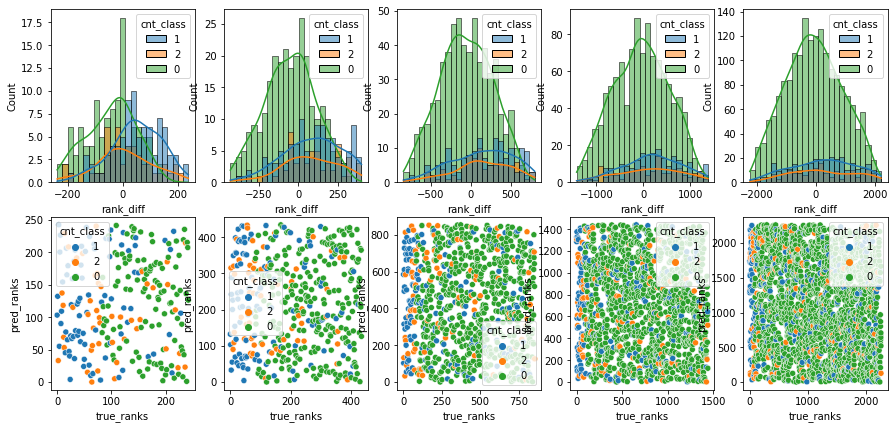

In [129]:
model_names = ['GraphConv']
feat_structs = ['agg_simp']
metrics_at = ['kendall@5', 'kendall@10', 'kendall@25', 'kendall@50', 'kendall@100']

fig, axes = plt.subplots(2, len(metrics_at), figsize=(15,7))
for model_name, feat_struct in zip(model_names, feat_structs):
    for i, metric in enumerate(metrics_at):
        df = preprocess_data(model_name, feat_struct, metric)
        #sns.scatterplot(data=df, x='cnt_class', y='rank_diff_abs', hue='true_ranks', ax=axes[0, i])
        #sns.scatterplot(data=df, x='rank_diff_abs', y='cnt_class', hue='true_ranks', ax=axes[0, i])
        sns.histplot(data=df, x='rank_diff', hue='cnt_class', ax=axes[0, i], kde=True, bins=25)
        sns.scatterplot(data=df, x='true_ranks', y='pred_ranks', ax=axes[1, i], hue='cnt_class')

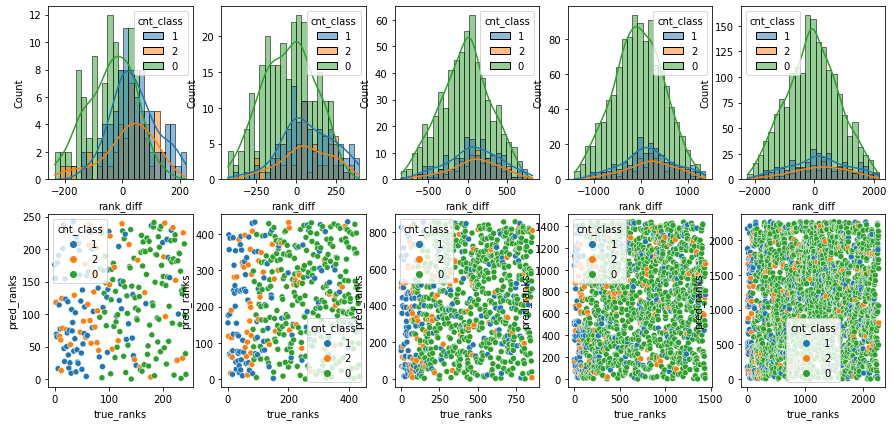

In [221]:
model_names = ['GraphSage']
feat_structs = ['temporal_edges']
metrics_at = ['kendall@5', 'kendall@10', 'kendall@25', 'kendall@50', 'kendall@100']

evol_0, evol_1, evol_2 = [], [], []
df_tot = pd.DataFrame()

fig, axes = plt.subplots(2, len(metrics_at), figsize=(15,7))
for model_name, feat_struct in zip(model_names, feat_structs):
    for i, metric in enumerate(metrics_at):
        df = preprocess_data(model_name, feat_struct, metric)
        #sns.scatterplot(data=df, x='cnt_class', y='rank_diff_abs', hue='true_ranks', ax=axes[0, i])
        sns.histplot(data=df, x='rank_diff', hue='cnt_class', ax=axes[0, i], kde=True, bins=25)
        #sns.scatterplot(data=df, x='rank_diff_abs', y='cnt_class', hue='true_ranks', ax=axes[0, i])
        sns.scatterplot(data=df, x='true_ranks', y='pred_ranks', ax=axes[1, i], hue='cnt_class')

        count_classes = df['cnt_class'].value_counts()
        evol_0.append(count_classes[0])
        evol_1.append(count_classes[1])
        evol_2.append(count_classes[2])

        df_tot = pd.concat([df_tot, df])

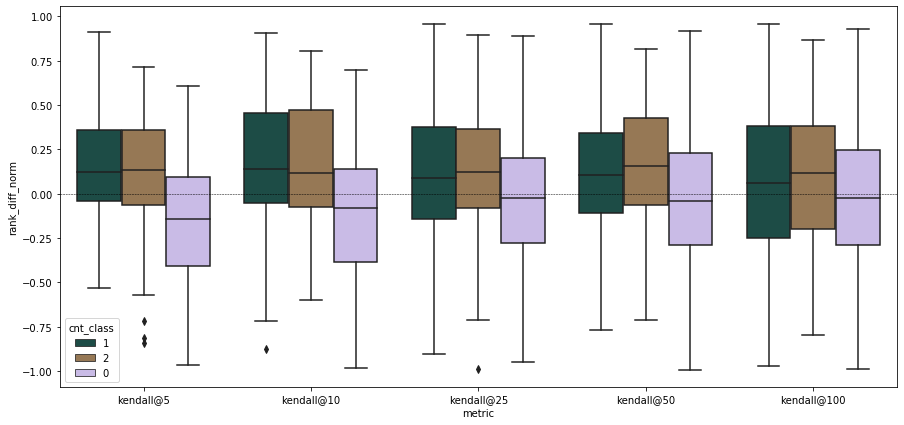

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
g = sns.boxplot(
        #data=df_tot.loc[(df_tot['metric']=='kendall@5') | (df_tot['metric']=='kendall@10')], 
        data=df_tot,
        x='metric', y='rank_diff_norm', 
        palette='cubehelix', hue='cnt_class')
g.axhline(0, ls='--', color='black', linewidth=0.5);

[Text(0, 0, '@10'), Text(0, 0, '@25'), Text(0, 0, '@50'), Text(0, 0, '@100')]

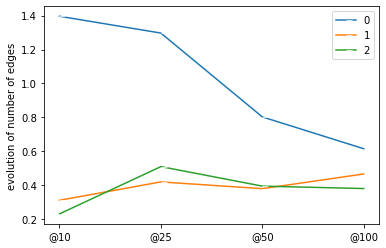

In [169]:
evol_0 = np.array(evol_0)
evol_1 = np.array(evol_1)
evol_2 = np.array(evol_2)
x = range(len(evol_0)-1)
fig, ax = plt.subplots(1, 1)
sns.lineplot(x, (evol_0[1:] - evol_0[:-1]) / evol_0[:-1], label='0', marker=True)
sns.lineplot(x, (evol_1[1:] - evol_1[:-1]) / evol_1[:-1], label='1', marker=True)
sns.lineplot(x, (evol_2[1:] - evol_2[:-1]) / evol_2[:-1], label='2', marker=True)
plt.legend()
ax.set_ylabel('evolution of number of edges')
ax.set_xticks(x)
ax.set_xticklabels(['@10', '@25', '@50', '@100'])